In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from ast import literal_eval
import itertools

In [ ]:
class preprocessing:
    def __init__(self):
        self.ratings = pd.read_csv('./datasets/ratings.csv')
        self.credits = pd.read_csv("./datasets/credits.csv")
        self.movies = pd.read_csv("./datasets/movies_metadata.csv")
        self.preprocessing_data()
        self.keywords = pd.read_csv("./datasets/keywords.csv")
        # self.links = pd.read_csv("./datasets/links.csv")

    def preprocessing_data(self):
        self.movies['id'] = pd.to_numeric(self.movies['id'], errors='coerce')
        self.movies = self.movies.dropna(subset=['id'])
        self.movies['id'] = self.movies['id'].astype('int64')
        self.movies = self.movies.convert_dtypes()
        self.movies = self.movies[self.movies['id'].isin(self.credits['id'])]
        
    # Funció per mostrar la distribució de les puntuacions    
    def mostra_distribucio_ratings(self):
        plt.figure(figsize=(10, 6))
        self.ratings['rating'].hist(bins=20, edgecolor='black')
        plt.title('Distribució de Puntuacions')
        plt.xlabel('Puntuació')
        plt.ylabel('Nombre de Vots')
        plt.grid(False)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
        plt.show()

    # Funció per a analitzar les mètriques de les pel·lícules
    def analitza_metrics_pellicules(self, min_vots):
        print(f"Total de pel·lícules: {self.movies.shape[0]}\n")
        print(f"Valors nulls a les pel·lícules:\n{self.movies.isnull().sum()}\n")
        print(f"Pel·lícules més votades:\n{self.movies.sort_values('vote_count', ascending=False)[['id','title', 'vote_count', 'vote_average']].head(10)}\n")
        print(f"Pel·lícules amb millor puntuació i més de {min_vots} vots:\n{self.movies[self.movies['vote_count'] > min_vots].sort_values('vote_average', ascending=False)[['id','title', 'vote_count', 'vote_average']].head(10)}\n")

    # Funció per mostrar les pel·lícules més valorades segons la puntuació ponderada
    def mostra_pellicules_mes_valorades(self):
        C = self.movies['vote_average'].mean()
        m = self.movies['vote_count'].quantile(0.3)
        self.movies["puntuacio_ponderada"] = (self.movies['vote_count']*self.movies['vote_average'] + C*m) / (self.movies['vote_count'] + m)
        top20 = self.movies.sort_values('puntuacio_ponderada', ascending=False).drop_duplicates('title').head(20)
        sns.barplot(x='puntuacio_ponderada', y='title', data=top20, palette='viridis')
        plt.title('Top 20 Pel·lícules per Puntuació Ponderada', fontsize=16)
        plt.xlabel('Puntuació Ponderada (PP)', fontsize=12)
        plt.ylabel('Títol de la Pel·lícula', fontsize=12)
        min_pp = top20['puntuacio_ponderada'].min()
        max_pp = top20['puntuacio_ponderada'].max()
        plt.xlim(min_pp - 0.1, max_pp + 0.1)
        for index, value in enumerate(top20['puntuacio_ponderada']):
            plt.text(value - 0.001, index, f'{value:.3f}', color='black', va="center")

        plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        plt.show()
    
    # Funció per analitzar els gèneres de les pel·lícules
    def analitza_generes(self):
        self.movies['genres'] = self.movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
        tots_generes = self.movies['genres'].explode()
        generes = tots_generes.value_counts().reset_index()
        generes.columns = ['gènere', 'comptador']
        plt.figure(figsize=(10, 6))
        sns.barplot(x='comptador', y='gènere', data=generes, palette='viridis')
        plt.title('Distribució de Gèneres')
        plt.xlabel('Nombre de Pel·lícules')
        plt.ylabel('Gènere')
        plt.show()

    # Funció per comptar pel·lícules per intervals de durada
    def compta_pellicules_per_durada(self):
        mv = self.movies.dropna(subset=['runtime', 'popularity'])
        mv['popularity'] = mv['popularity'].astype(float)
        intervals = [0, 30, 80, 130, np.inf]
        etiquetes = ['Curtmetratge', 'Pel·lícula curta', 'Pel·lícula', 'Pel·lícula llarga']
        runtime = pd.to_numeric(mv['runtime'], errors='coerce')
        durada = pd.cut(runtime, bins=intervals, labels=etiquetes, right=False)
        comptador_intervals = durada.value_counts().sort_index()
        popularitat_intervals = mv.groupby(durada)['popularity'].mean()
        popularitat_intervals = mv.groupby(durada)['popularity'].mean()
        taula_intervals = pd.DataFrame({'Quantitat': comptador_intervals,'Popularitat Mitjana': popularitat_intervals})
        print(taula_intervals)


    # Funció per mirar la relació entre la puntuació i el nombre de vots
    def vote_vs_rate(self):
        correlacio = self.movies[['vote_count', 'vote_average']].corr().iloc[0, 1]
        print(f"Correlació entre Nombre de Vots i Puntuació: {correlacio:.2f}")
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='vote_count', y='vote_average', data=self.movies, alpha=0.7)
        plt.title('Puntuació vs Nombre de Vots')
        plt.xlabel('Nombre de Vots')
        plt.ylabel('Puntuació')
        plt.show()

    # Funció per analitzar si els directors i actors més populars influeixen en la popularitat de les pel·lícules 
    def analitza_directors_actors(self):
        crew = self.credits['crew'].apply(literal_eval)
        cast = self.credits['cast'].apply(literal_eval)

        self.credits['directors'] = crew.apply(lambda x: [i['name'] for i in x if i['job'] == 'Director'])
        directors = self.credits.explode('directors')[['id', 'directors']].dropna(subset=['directors'])

        directors_counts = directors['directors'].value_counts().reset_index()
        directors_counts.columns = ['Director', 'Nombre de Pel·lícules']

        directors_ids = directors.groupby('directors')['id'].apply(list).reset_index()
        directors_ids.columns = ['Director', 'id']

        directors_final = pd.merge(directors_counts, directors_ids, on='Director')
        top10_directors = directors_final.head(10)
        
        
        self.credits['actors'] = cast.apply(lambda x: [i['name'] for i in x])
        actors = self.credits.explode('actors')[['id', 'actors']].dropna(subset=['actors'])

        actors_counts = actors['actors'].value_counts().reset_index()
        actors_counts.columns = ['Actor', 'Nombre de Pel·lícules']

        actors_ids = actors.groupby('actors')['id'].apply(list).reset_index()
        actors_ids.columns = ['Actor', 'id']

        actors_final = pd.merge(actors_counts, actors_ids, on='Actor')
        top10_actors = actors_final.head(10)
        
        print(f"Actors més influents:\n{top10_actors[['Actor','Nombre de Pel·lícules']]}\n")
        print(f"Directors més influents:\n{top10_directors[['Director', 'Nombre de Pel·lícules']]}\n")
        
        dins_millors_pelis = {}
        top20 = self.movies.sort_values('puntuacio_ponderada', ascending=False).drop_duplicates('title').head(20)
        for (_, actor_row), (_, director_row) in zip(top10_actors.iterrows(), top10_directors.iterrows()):
            dins_millors_pelis[actor_row['Actor']] = ['actor', 0]
            dins_millors_pelis[director_row['Director']] = ['director', 0]
            for peli_actor in actor_row['id']:
                if peli_actor in top20['id'].values:  
                    dins_millors_pelis[actor_row['Actor']][1] += 1
            for peli_director in director_row['id']:
                if peli_director in top20['id'].values:
                    dins_millors_pelis[director_row['Director']][1] += 1
        
        data = {'Nom': [], 'Rol': [], 'Comptador': []}
        for nom, (rol, comptador) in dins_millors_pelis.items():
            data['Nom'].append(nom)
            data['Rol'].append(rol)
            data['Comptador'].append(comptador)

        df = pd.DataFrame(data)

        # Gràfic de barres
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Comptador', y='Nom', hue='Rol', data=df, palette='viridis')
        plt.title('Actors i Directors més repetits a les 20 pel·lícules més votades', fontsize=16)
        plt.xlabel('Nombre de Vegades a les 20 Millors Pel·lícules', fontsize=12)
        plt.ylabel('Nom', fontsize=12)
        plt.legend(title='Rol', loc='upper right')
        plt.show()

In [ ]:
p = preprocessing()

<ipython-input-2-6e31d4d6b21f>:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  self.movies = pd.read_csv("./datasets/movies_metadata.csv")


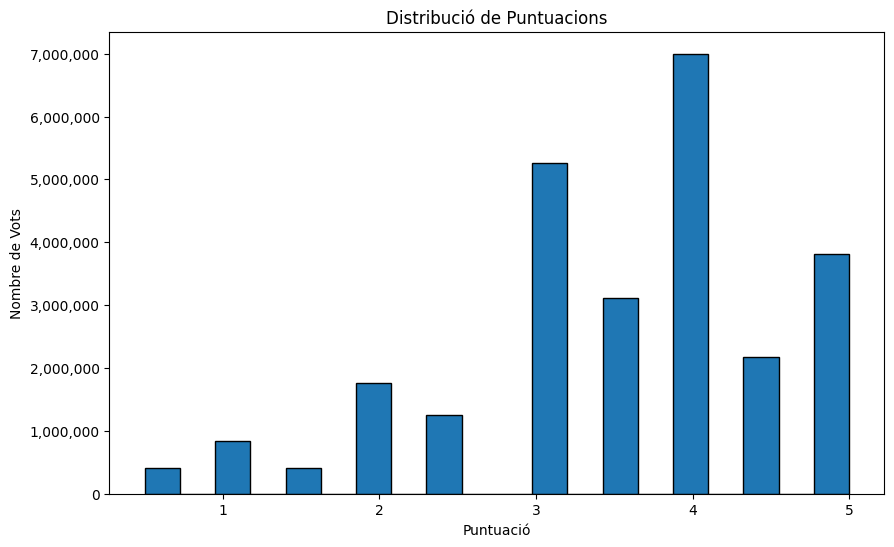

In [ ]:
p.mostra_distribucio_ratings()

In [ ]:
p.analitza_metrics_pellicules(1000)

Total de pel·lícules: 45462

Valors nulls a les pel·lícules:
adult                        0
belongs_to_collection    40971
budget                       0
genres                       0
homepage                 37683
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   3
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      3
runtime                    260
spoken_languages             3
status                      84
tagline                  25050
title                        3
video                        3
vote_average                 3
vote_count                   3
dtype: int64

Pel·lícules més votades:
           id                    title  vote_count  vote_average
15480   27205                Inception       14075           8.1
12481     155          The

<ipython-input-2-6e31d4d6b21f>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='puntuacio_ponderada', y='title', data=top20, palette='viridis')


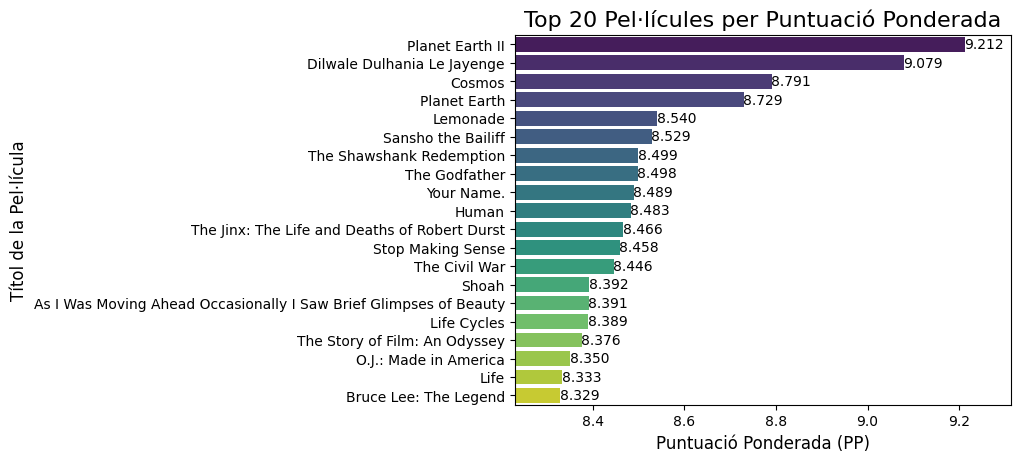

In [ ]:
p.mostra_pellicules_mes_valorades()

<ipython-input-2-6e31d4d6b21f>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='comptador', y='gènere', data=generes, palette='viridis')


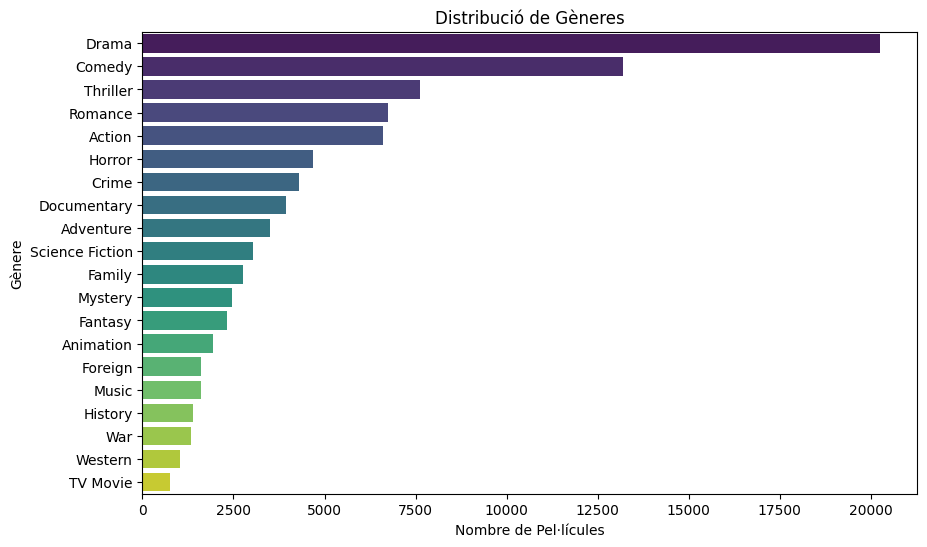

In [ ]:
p.analitza_generes()

In [ ]:
p.compta_pellicules_per_durada()

                   Quantitat  Popularitat Mitjana
runtime                                          
Curtmetratge            2838             0.890836
Pel·lícula curta        4779             1.241880
Pel·lícula             34339             3.174460
Pel·lícula llarga       3246             4.708041


<ipython-input-2-6e31d4d6b21f>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mv['popularity'] = mv['popularity'].astype(float)
<ipython-input-2-6e31d4d6b21f>:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  popularitat_intervals = mv.groupby(durada)['popularity'].mean()
<ipython-input-2-6e31d4d6b21f>:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  popularitat_int

Correlació entre Nombre de Vots i Puntuació: 0.12


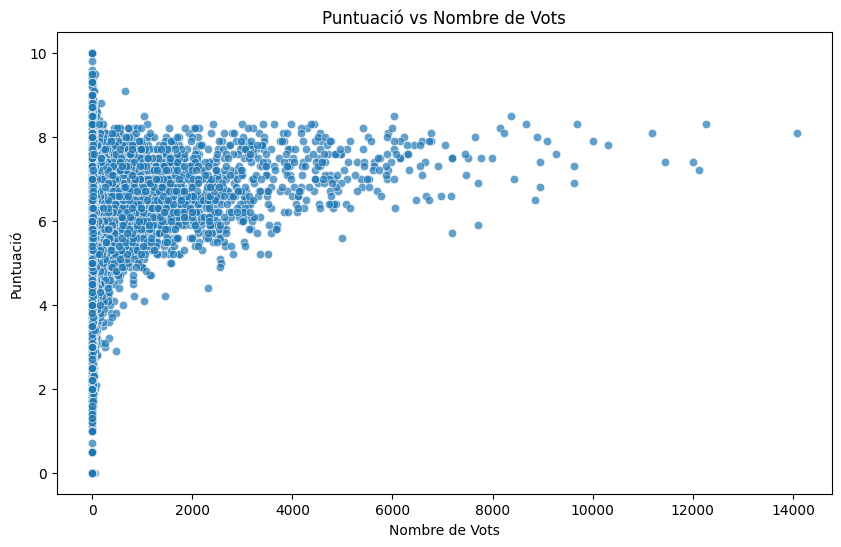

In [ ]:
p.vote_vs_rate()

Actors més influents:
               Actor  Nombre de Pel·lícules
0       Bess Flowers                    241
1    Christopher Lee                    148
2         John Wayne                    125
3  Samuel L. Jackson                    123
4      Michael Caine                    110
5   Gérard Depardieu                    110
6     John Carradine                    109
7  Donald Sutherland                    109
8        Jackie Chan                    108
9       Frank Welker                    107

Directors més influents:
           Director  Nombre de Pel·lícules
0         John Ford                     68
1    Michael Curtiz                     65
2     Werner Herzog                     55
3  Alfred Hitchcock                     53
4    Georges Méliès                     51
5   Jean-Luc Godard                     50
6       Woody Allen                     49
7      Sidney Lumet                     46
8   Charlie Chaplin                     44
9       Raoul Walsh                   

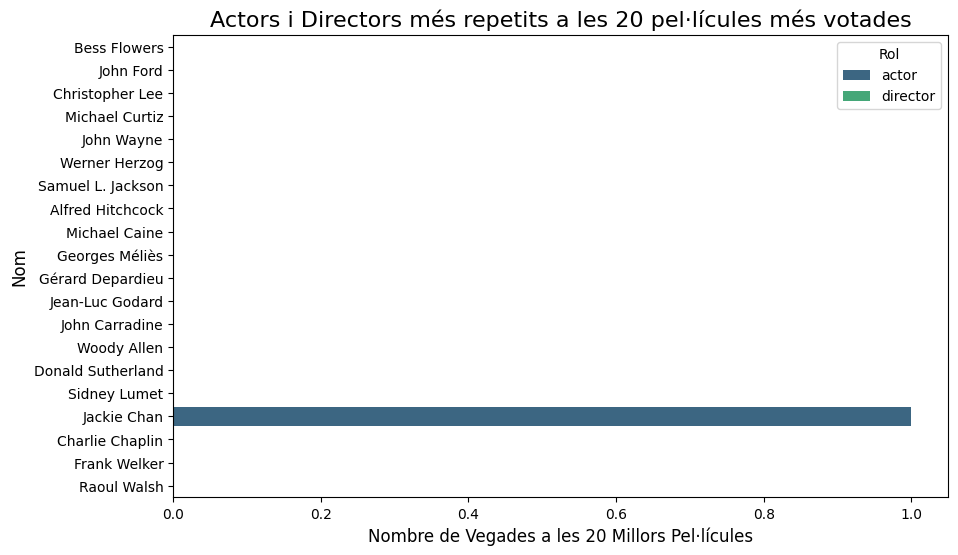

In [ ]:
p.analitza_directors_actors()